In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


import warnings
# Code was showing some warnings, from stack overflow optimal answer was to include this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df= pd.read_csv("fetal_health.csv")

In [3]:
X = df.iloc[:, :-1]

y = df.iloc[:, -1]




## Splitting & Using GB


In [4]:
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradient_boosting.fit(X_train, y_train)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(gradient_boosting, X_train, y_train, cv=kf)

print(f"Cross-Validation Results: {cross_val_results}")
print(f"Mean Accuracy: {cross_val_results.mean():.2f}")
y_train_converted = y_train - 1

start_time = time.time()
gradient_boosting.fit(X_train, y_train_converted)
end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time} seconds")
y_test_converted = y_test - 1

y_pred = gradient_boosting.predict(X_test)


Cross-Validation Results: [0.94705882 0.94117647 0.94705882 0.94705882 0.94117647]
Mean Accuracy: 0.94
Training time: 1.4370315074920654 seconds


## Using Evaluation Metrics

Accuracy =  94.83568075117371 %
Precision =  0.9130480445771597
Recall =  0.9212040704497602
F1-score =  0.9166163584874228


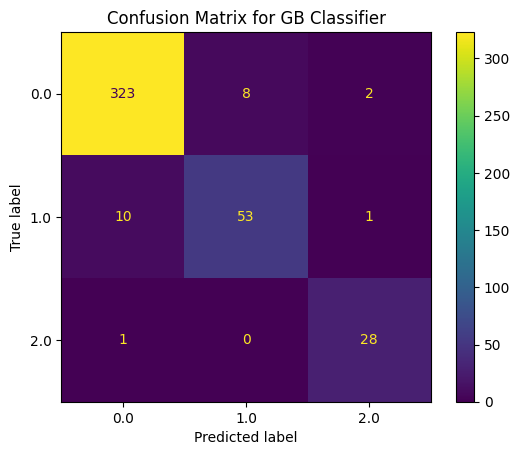

Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       333
         1.0       0.87      0.83      0.85        64
         2.0       0.90      0.97      0.93        29

    accuracy                           0.95       426
   macro avg       0.91      0.92      0.92       426
weighted avg       0.95      0.95      0.95       426



In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)


print("Accuracy = ", accuracy_score(y_test_converted, y_pred) * 100, "%")
print("Precision = ", precision_score(y_test_converted, y_pred, average='macro'))
print("Recall = ", recall_score(y_test_converted, y_pred, average='macro'))
print("F1-score = ", f1_score(y_test_converted, y_pred, average='macro'))

conf_matrix = confusion_matrix(y_test_converted, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_train_converted))
disp.plot()
plt.title('Confusion Matrix for GB Classifier')
plt.show()

print("Classification Report")
print(classification_report(y_test_converted, y_pred))


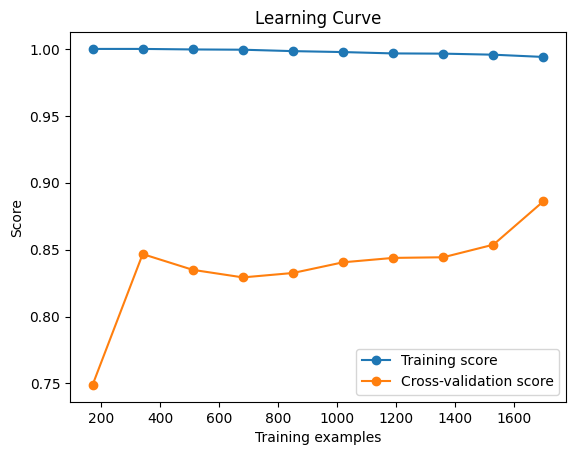

In [6]:
train_sizes, train_scores, test_scores = learning_curve(gradient_boosting, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

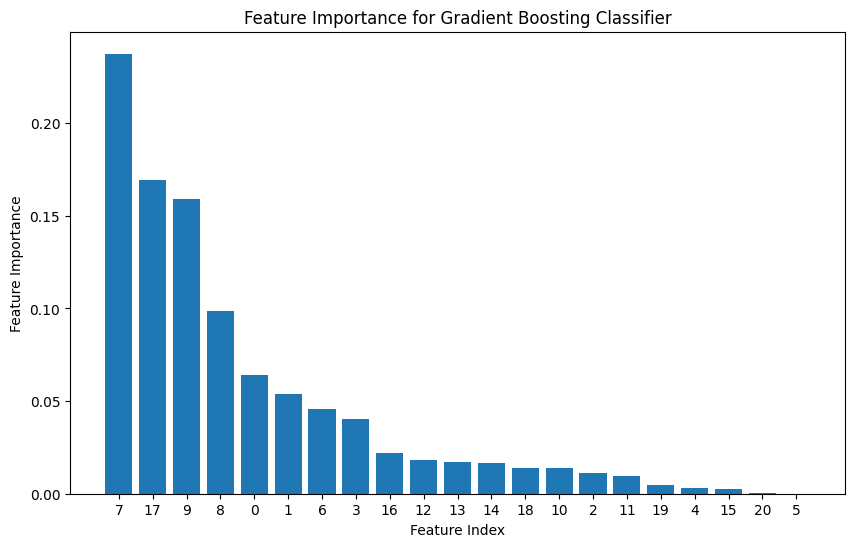

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_classifier.fit(X_train, y_train)

feature_importances = gb_classifier.feature_importances_

sorted_features_indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[sorted_features_indices])
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Gradient Boosting Classifier')
plt.xticks(range(X.shape[1]), sorted_features_indices)  
plt.show()


In [8]:
top_k_features_indices = sorted_features_indices[:16]
print("Indices of Important Features:", top_k_features_indices)

X_selected = X.iloc[:, top_k_features_indices]

Indices of Important Features: [ 7 17  9  8  0  1  6  3 16 12 13 14 18 10  2 11]


## Checking class distribution

Class Distribution:
fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64
Coefficient of Variation (CV): 1.1595095195631708


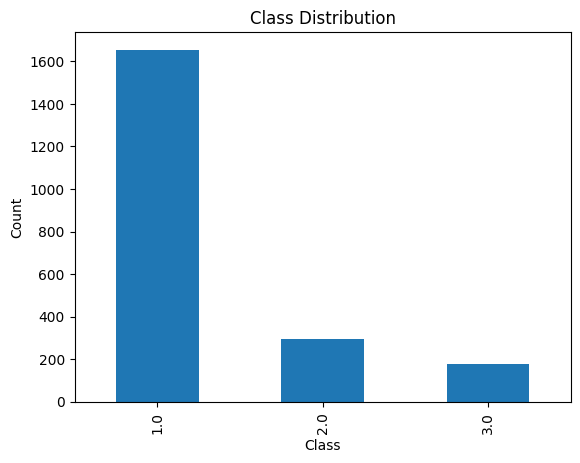

In [9]:

target_column = 'fetal_health'

class_distribution = df[target_column].value_counts()

mean_class_size = class_distribution.mean()
std_class_size = class_distribution.std()
imbalance_cv = std_class_size / mean_class_size

print(f"Class Distribution:\n{class_distribution}")
print(f"Coefficient of Variation (CV): {imbalance_cv}")

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Applying SMOTE


In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


print("Feature names during training:", X_resampled.columns)
print("Feature names in the test set:", X_test.columns)
X_test_aligned = X_test[X_resampled.columns]

Feature names during training: Index(['abnormal_short_term_variability', 'histogram_mean',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_short_term_variability', 'baseline value',
       'accelerations', 'prolongued_decelerations', 'uterine_contractions',
       'histogram_mode', 'histogram_min', 'histogram_max',
       'histogram_number_of_peaks', 'histogram_median',
       'mean_value_of_long_term_variability', 'fetal_movement',
       'histogram_width'],
      dtype='object')
Feature names in the test set: Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_

Class Distribution:
fetal_health
2.0    1655
1.0    1655
3.0    1655
Name: count, dtype: int64
Coefficient of Variation (CV): 0.0


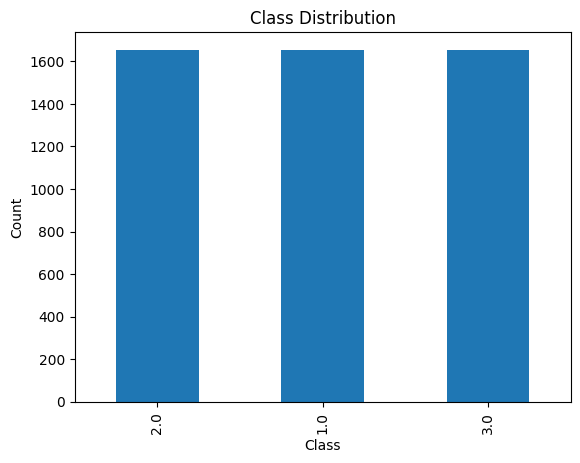

In [11]:
y_resampled_series = pd.Series(y_resampled)

# Calculate and plot class distribution
class_distribution = y_resampled_series.value_counts()

mean_class_size = class_distribution.mean()
std_class_size = class_distribution.std()
imbalance_cv = std_class_size / mean_class_size

print(f"Class Distribution:\n{class_distribution}")
print(f"Coefficient of Variation (CV): {imbalance_cv}")

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Using GB

In [12]:


from sklearn.model_selection import cross_val_score, KFold
gradient_boosting_after = GradientBoostingClassifier()
gradient_boosting_after.fit(X_resampled, y_resampled)


# k_folds = 5 

# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


# y_pred_after = cross_val_predict(gradient_boosting_after, X_resampled, y_resampled, cv=kf)
y_pred_full = gradient_boosting_after.predict(X_resampled)
y_pred_test = gradient_boosting_after.predict(X_test_aligned)



Holdout CV : 0.9305882352941176
k-Fold CV : 0.9449665831244779
Stratified k-Fold CV: 0.9416788794018945


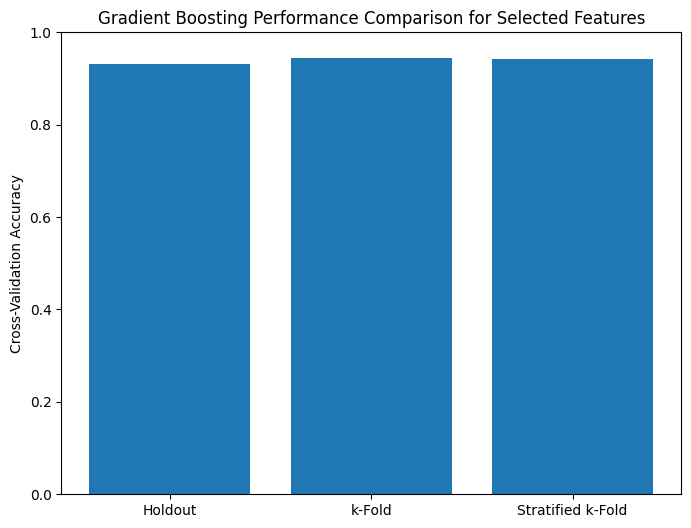

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier


cv_scores_holdout = []
cv_scores_kfold = []
cv_scores_stratified_kfold = []

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradient_boosting_classifier.fit(X_train, y_train)

scores_holdout = cross_val_score(gradient_boosting_classifier, X_train, y_train, cv=2, scoring='accuracy')
cv_scores_holdout.append(scores_holdout.mean())
print(f'Holdout CV : {scores_holdout.mean()}')

kf = KFold(n_splits=4, shuffle=True, random_state=42)
scores_kfold = cross_val_score(gradient_boosting_classifier, X_selected, y, cv=kf, scoring='accuracy')
cv_scores_kfold.append(scores_kfold.mean())
print(f'k-Fold CV : {scores_kfold.mean()}')

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scores_stratified_kfold = cross_val_score(gradient_boosting_classifier, X_selected, y, cv=skf, scoring='accuracy')
cv_scores_stratified_kfold.append(scores_stratified_kfold.mean())
print(f'Stratified k-Fold CV: {scores_stratified_kfold.mean()}')

plt.figure(figsize=(8, 6))
plt.bar(['Holdout', 'k-Fold', 'Stratified k-Fold'],
        [cv_scores_holdout[0], cv_scores_kfold[0], cv_scores_stratified_kfold[0]])
plt.title(f'Gradient Boosting Performance Comparison for Selected Features')
plt.ylabel('Cross-Validation Accuracy')
plt.ylim([0, 1])
plt.show()


## Using Evaluation Metrics

Accuracy (Resampled): 98.75125881168178 %
Precision (macro, Resampled): 0.9875652350957007
Recall (macro, Resampled): 0.9875125881168177
F1-score (macro, Resampled): 0.9875244195620598
Confusion Matrix (Resampled):


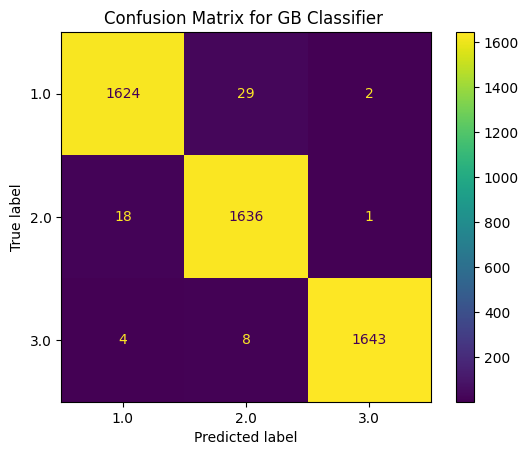

Classification Report (Resampled):
              precision    recall  f1-score   support

         1.0       0.99      0.98      0.98      1655
         2.0       0.98      0.99      0.98      1655
         3.0       1.00      0.99      1.00      1655

    accuracy                           0.99      4965
   macro avg       0.99      0.99      0.99      4965
weighted avg       0.99      0.99      0.99      4965

Test Accuracy: 97.65258215962442 %
Test Precision (macro): 0.9656687723152979
Test Recall (macro): 0.9731606606606608
Test F1-score (macro): 0.9693388940376892


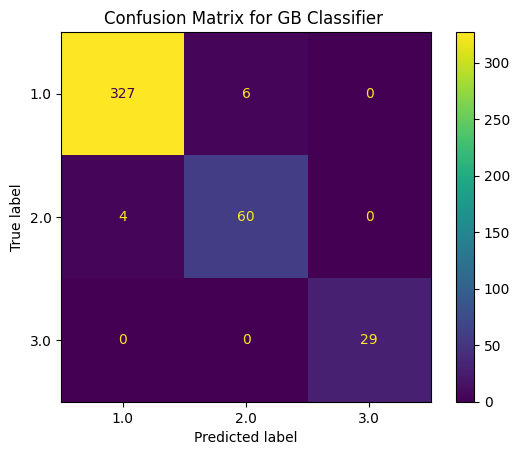

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

accuracy_resampled = accuracy_score(y_resampled, y_pred_full)
precision_resampled = precision_score(y_resampled, y_pred_full, average='macro')
recall_resampled = recall_score(y_resampled, y_pred_full, average='macro')
f1_resampled = f1_score(y_resampled, y_pred_full, average='macro')

conf_matrix_resampled = confusion_matrix(y_resampled, y_pred_full)
class_report_resampled = classification_report(y_resampled, y_pred_full)

print("Accuracy (Resampled):", accuracy_resampled * 100, "%")
print("Precision (macro, Resampled):", precision_resampled)
print("Recall (macro, Resampled):", recall_resampled)
print("F1-score (macro, Resampled):", f1_resampled)

print("Confusion Matrix (Resampled):")
conf_matrix = confusion_matrix(y_resampled, y_pred_full)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for GB Classifier ')
plt.show()
print("Classification Report (Resampled):")
print(class_report_resampled)


test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro')
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy * 100, "%")
print("Test Precision (macro):", test_precision)
print("Test Recall (macro):", test_recall)
print("Test F1-score (macro):", test_f1)

conf_matrix = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for GB Classifier ')
plt.show()

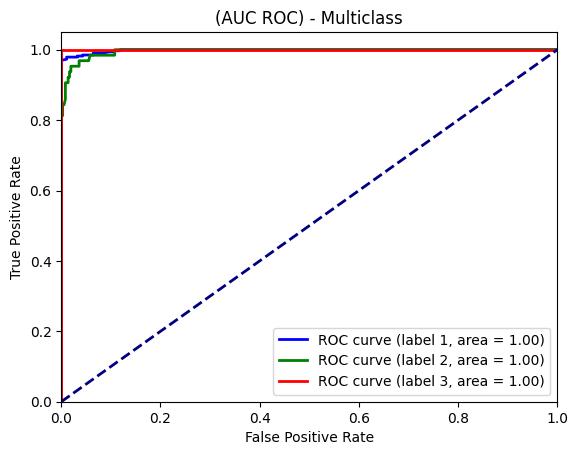

In [15]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = gradient_boosting_after.predict_proba(X_test)


plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


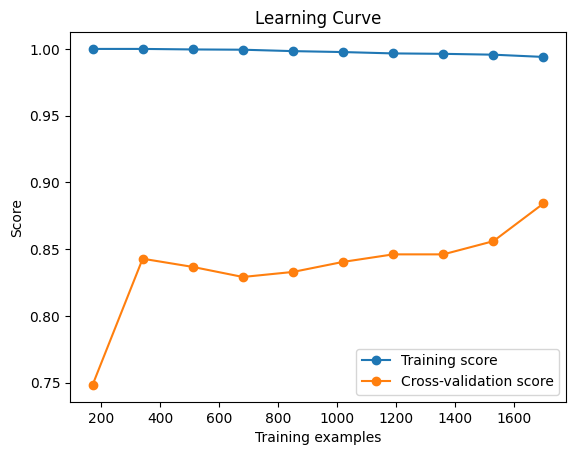

In [16]:
train_sizes, train_scores, test_scores = learning_curve(gradient_boosting_after, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

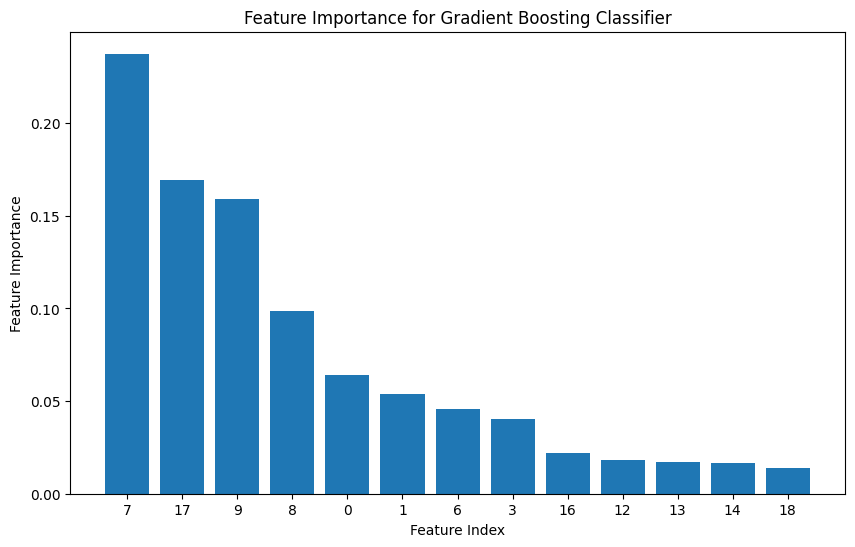

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_classifier.fit(X_train, y_train)

feature_importances = gb_classifier.feature_importances_

sorted_features_indices = feature_importances.argsort()[::-1]
num_features_to_plot = 13

plt.figure(figsize=(10, 6))
plt.bar(range(num_features_to_plot), feature_importances[sorted_features_indices[:num_features_to_plot]])
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Gradient Boosting Classifier')
plt.xticks(range(num_features_to_plot), sorted_features_indices[:num_features_to_plot])  

plt.show()
